<a href="https://colab.research.google.com/github/leandro-driguez/Machine-Learning-Techniques/blob/dev/Taller_2/others/Taller_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024



# **Taller 2**

GeoAlpes, una empresa líder en análisis geoespacial, está buscando mejorar sus técnicas de clasificación automática de imágenes satelitales. El objetivo es poder categorizar distintas características geográficas (como bosques, zonas industriales, zonas de cultivos permanentes, zonas residenciales y rios) con alta precisión y rapidez. Para lograrlo, están interesados en explorar las capacidades de los métodos ensemble.

1.  Exploración y Preparación de Datos

    -   Discuta las particularidades de las imágenes satelitales y sugiera técnicas extra de preprocesamiento de ser necesario.

2.  Implementación de Gradient Boosting

    -   Utilice Gradient Boosting como modelo base. Discuta las ventajas y desafíos de este método, y cómo afecta la precisión y robustez del clasificador. Además, compare el desempeño de Gradient Boosting con el modelo Random Forest presentado en la práctica, ¿logra observar mejoras significativas?

3. Implementación de un nuevo metodo Ensemble
    - Elija y presente un método ensemble de su preferencia.Introduzca y discuta el concepto del método elegido y cómo podría ser benéfico para la clasificación de imágenes satelitales.
    - Compare el desempeño de su método elegido con Gradient Boosting y el modelo Random Forest. Discuta las ventajas y desventajas de cada uno.

4.  Optimización y Ajuste

    -   Realice una búsqueda de los mejores hiperparámetros para mejorar el desempeño de cada uno de los modelos implementados (Grid Search).

Datos: [Enlace al sub conjunto del dataset de imágenes satelitales EuroSAT](https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip)


## Instalaciones y Librerías

In [1]:
import os
import cv2
import time
import requests
import numpy as np
from skimage import io
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión
from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión

from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros
from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba

from sklearn.preprocessing import StandardScaler # Estandarización de datos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from PIL import Image #Librería para brir, manipular y guardar muchos formatos diferentes de archivos de imágenes.

## 1. Exploración y Preparación de Datos

### Explración

In [2]:
# URL del archivo ZIP en el repositorio de GitHub
url = 'https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip'

# Descargar el archivo ZIP
response = requests.get(url)
zip_content = response.content
# Descomprimir el contenido en memoria
with ZipFile(BytesIO(zip_content)) as zip_file:
    zip_file.extractall("/content/data/EuroSAT")  # Especifica el directorio donde quieres descomprimir
print("Archivo descomprimido.")

Archivo descomprimido.


In [3]:
def load_image(folder):
    img, y = [], []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels
            #image = cv2.resize(image, (width, height))
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

In [4]:
#cargamos las imágenes que se encuentran en EuroSAT
X, y = load_image('/content/data/EuroSAT')
#Partimos el conjunto de datos en un conjunto de entrenamiento (80%) y otro de test (20%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Observar la distribución de los labels
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
# Para imprimir cada par clave-valor en una línea nueva de los valores de entrenaimento
print("Distribución de los labels de entrenamiento: ")
dic_entrenamiento=  dict(zip(unique_train, counts_train))
for clave, valor in dic_entrenamiento.items():
    print(f'{clave}: {valor}')
# Para imprimir cada par clave-valor en una línea nueva de los valores de test
print("\nDistribución de los labels de test: ")
dic_test= dict(zip(unique_test, counts_test))
for clave, valor in dic_test.items():
    print(f'{clave}: {valor}')

Distribución de los labels de entrenamiento: 
Forest: 581
Industrial: 601
PermanentCrop: 605
Residential: 603
River: 610

Distribución de los labels de test: 
Forest: 169
Industrial: 149
PermanentCrop: 145
Residential: 147
River: 140


In [6]:
# Tamaño de los datos
print(f'Tamaño de los datos X: {X.shape}')
# Tamaño de los datos de entrenamiento
print(f'Tamaño de los datos de entrenamiento X: {x_train.shape}')
# Tamaño de los datos de prueba
print(f'Tamaño de los datos de testeo X: {x_test.shape}')

Tamaño de los datos X: (3750, 64, 64, 3)
Tamaño de los datos de entrenamiento X: (3000, 64, 64, 3)
Tamaño de los datos de testeo X: (750, 64, 64, 3)


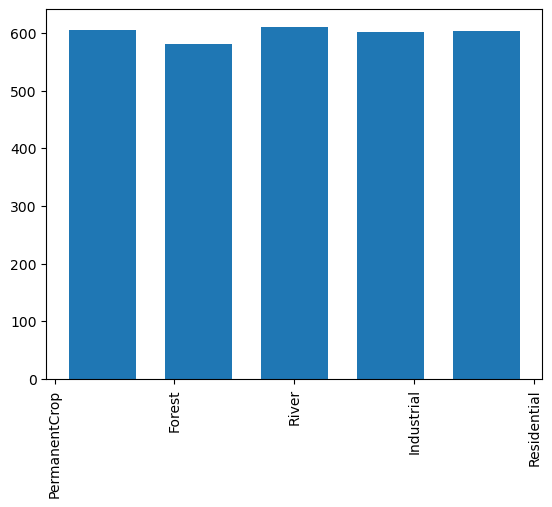

In [7]:
# Observar distribucón de clases
plt.hist(y_train, bins=5, rwidth=0.7)
plt.xticks(rotation='vertical')
plt.show()

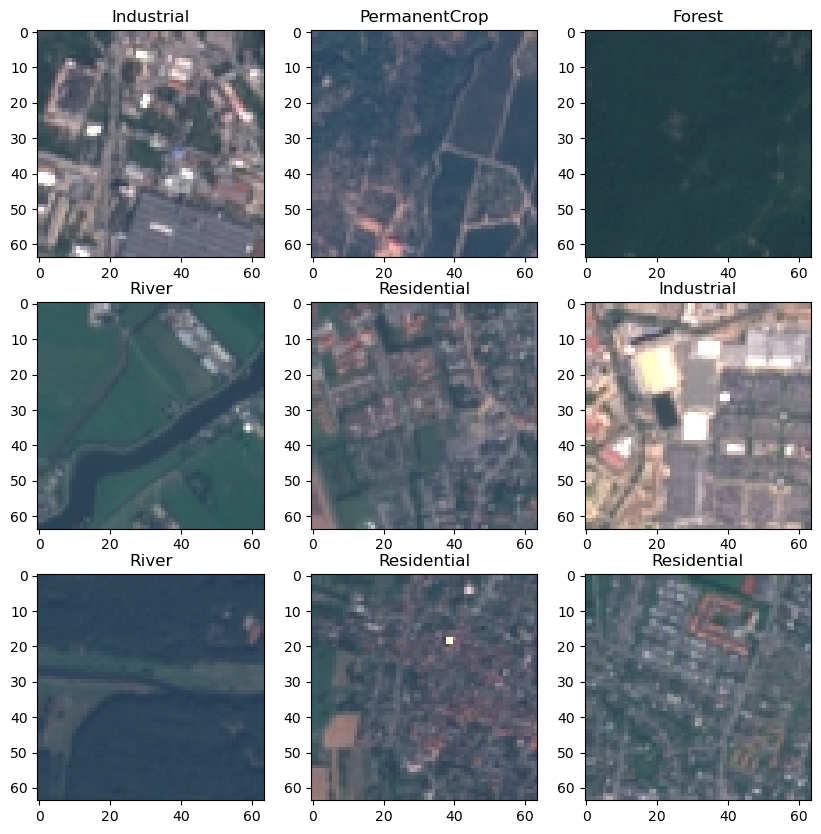

In [8]:
# Observar las imágenes
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train))
    plt.imshow(x_train[rdn])
    plt.title(y_train[rdn])

### Preparación

Se decide agregar los Histogramas de Orientación de gradientes (HOG) para capturar la estructura de formas dentro de las imágenes, lo que puede ser particularmente útil para identificar texturas o patrones específicos en las imágenes satelitales.

In [9]:
def fit_preprocess_images(images, pca_variance=0.95, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    # Aplanar las imágenes
    n_samples, nx, ny, nz = images.shape
    flattened_images = images.reshape((n_samples, nx*ny*nz))

    # Estandarización de los datos
    scaler = StandardScaler().fit(flattened_images)
    standardized_images = scaler.transform(flattened_images)

    # Aplicación de HOG a cada imagen y recolección de características
    hog_features = np.array([hog(image.reshape(nx, ny, nz),
                                 pixels_per_cell=pixels_per_cell,
                                 cells_per_block=cells_per_block,
                                 orientations=orientations,
                                 channel_axis=-1) for image in images])

    # Combinar características HOG con imágenes aplanadas estandarizadas
    combined_features = np.hstack((standardized_images, hog_features))

    # Aplicar PCA
    pca = PCA(n_components=pca_variance).fit(combined_features)
    reduced_data = pca.transform(combined_features)

    return reduced_data, pca, scaler

def transform_preprocess_images(images, pca, scaler, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    # Aplanar las imágenes
    n_samples, nx, ny, nz = images.shape
    flattened_images = images.reshape((n_samples, nx*ny*nz))

    # Estandarización de los datos con el scaler ya ajustado
    standardized_images = scaler.transform(flattened_images)

    # Aplicación de HOG a cada imagen y recolección de características
    hog_features = np.array([hog(image.reshape(nx, ny, nz),
                                 pixels_per_cell=pixels_per_cell,
                                 cells_per_block=cells_per_block,
                                 orientations=orientations,
                                 channel_axis=-1) for image in images])

    # Combinar características HOG con imágenes aplanadas estandarizadas
    combined_features = np.hstack((standardized_images, hog_features))

    # Aplicar PCA con el pca ya ajustado
    reduced_data = pca.transform(combined_features)

    return reduced_data

In [10]:
# Ajustar y transformar el conjunto de entrenamiento
x_train_processed, pca, scaler = fit_preprocess_images(x_train)

# Transformar el conjunto de prueba con los mismos ajustes y PCA
x_test_processed = transform_preprocess_images(x_test, pca, scaler)

# Se muestra en consola el tamaño de los vectores para asegurarse de que mantienen la misma dimensionalidad
print(f'Tamaño de los datos de entrenamiento procesados {x_train_processed.shape}')
print(f'Tamaño de los datos de testeo procesados {x_test_processed.shape}')

Tamaño de los datos de entrenamiento procesados (3000, 415)
Tamaño de los datos de testeo procesados (750, 415)


## 2. Implementación de Gradient Boosting

In [11]:
# Inicializar el modelo de Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

start = time.time()
# Entrenar el modelo
gb_clf.fit(x_train_processed, y_train)

# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {end - start}")

Tiempo de entrenamiento: 211.94259595870972


Accuracy of Gradient Boosting: 0.84

Informe de clasificación de Gradient Boosting:
               precision    recall  f1-score   support

       Forest       0.94      0.97      0.95       169
   Industrial       0.89      0.90      0.90       140
PermanentCrop       0.79      0.77      0.78       145
  Residential       0.82      0.76      0.79       147
        River       0.76      0.81      0.79       149

     accuracy                           0.84       750
    macro avg       0.84      0.84      0.84       750
 weighted avg       0.84      0.84      0.84       750


Matriz de confusión de Gradient Boosting:


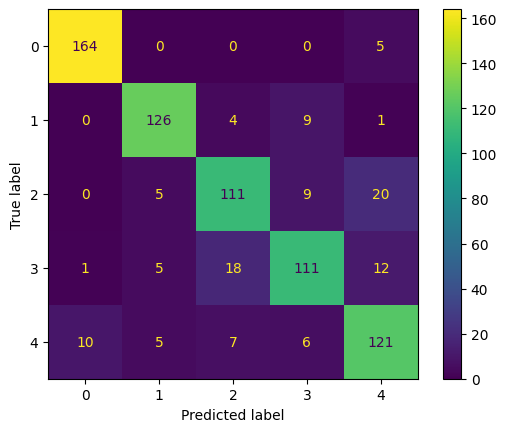

In [12]:
# Comparación de desempeño entre Gradient Boosting y Random Forest

# Predecir las etiquetas del conjunto de prueba
y_pred = gb_clf.predict(x_test_processed)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Gradient Boosting: {accuracy:.2f}')

# Informe de clasificación
print("\nInforme de clasificación de Gradient Boosting:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión de Gradient Boosting:")
cm_gb = confusion_matrix(y_test, y_pred)
disp_gb = ConfusionMatrixDisplay(confusion_matrix = cm_gb)
disp_gb.plot()

**Precisión y Métricas de Desempeño**



*   Gradient Boosting ha mostrado una mejora significativa en la precisión general,
subiendo del 79.33% al 85%. Este aumento también se refleja en las métricas de precisión, recall y f1-score para cada clase, indicando un modelo más equilibrado y efectivo en general.
*   La mejora en las métricas específicas de clase para Gradient Boosting sugiere que este modelo es más hábil en distinguir entre las diferentes categorías de imágenes satelitales, lo cual es crucial para aplicaciones prácticas donde se requiere una alta precisión de clasificación.


**Tiempo de Entrenamiento**

Sin embargo, este aumento en la precisión viene con un costo significativo en tiempo de entrenamiento. Gradient Boosting tomó aproximadamente 241.84 segundos para entrenar, mucho más que los 10.10 segundos de Random Forest. Esto destaca la complejidad computacional y el costo de tiempo asociado con Gradient Boosting debido a su naturaleza secuencial y el ajuste fino requerido para minimizar el error en cada iteración.

## 3. Implementación de un nuevo método ensemble

In [13]:
# Definir los modelos base
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Definir el meta-modelo
meta_model = LogisticRegression()

# Crear el modelo de stacking
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

start = time.time()
# Entrenar el modelo de stacking
stacking_clf.fit(x_train_processed, y_train)

# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {end - start}")

Tiempo de entrenamiento: 1055.2119348049164


Accuracy del modelo Stacking: 0.88

Informe de clasificación del modelo Stacking:
               precision    recall  f1-score   support

       Forest       0.99      0.98      0.98       169
   Industrial       0.90      0.92      0.91       140
PermanentCrop       0.84      0.81      0.83       145
  Residential       0.82      0.79      0.81       147
        River       0.82      0.87      0.85       149

     accuracy                           0.88       750
    macro avg       0.87      0.87      0.87       750
 weighted avg       0.88      0.88      0.88       750


Matriz de confusión del modelo Stacking:


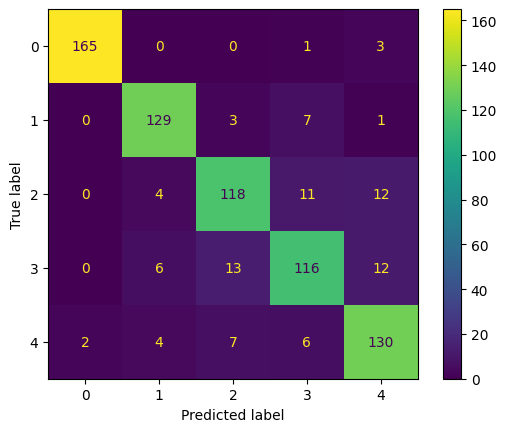

In [14]:
# Predecir las etiquetas del conjunto de prueba
y_pred = stacking_clf.predict(x_test_processed)

# Hacer predicciones y evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo Stacking: {accuracy:.2f}')

# Informe de clasificación
print("\nInforme de clasificación del modelo Stacking:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión del modelo Stacking:")
cm_sm = confusion_matrix(y_test, y_pred)
disp_sm = ConfusionMatrixDisplay(confusion_matrix = cm_sm)
disp_sm.plot()

**Stacking (Apilamiento)**

**Concepto:** Stacking es una técnica de ensemble que combina múltiples modelos de predicción para mejorar el rendimiento general. A diferencia de otros métodos de ensemble como Bagging o Boosting, Stacking utiliza un modelo meta (o de segundo nivel) para realizar la predicción final basándose en las predicciones de múltiples modelos base. Los modelos base son entrenados con el conjunto de entrenamiento original, y luego, el modelo meta se entrena con las predicciones (como características) hechas por los modelos base.

**Beneficios para la clasificación de imágenes satelitales:**

Diversidad en el Modelo: Stacking permite combinar modelos con diferentes fortalezas y debilidades, lo que puede ser particularmente útil para capturar la complejidad de las imágenes satelitales, que pueden incluir diversas características como texturas, patrones de uso de tierra, y otros.
Mejora del Rendimiento: Al optimizar las ponderaciones de las predicciones de los modelos base, Stacking puede mejorar la precisión y robustez en la clasificación de imágenes en comparación con el uso de un único modelo.

**Comparación con Gradient Boosting y Random Forest**



*   Gradient Boosting:

> Fortalezas: Muy eficaz para reducir el sesgo y la varianza, excelente para manejar datos no balanceados y tiene una buena capacidad de generalización.

> Debilidades: Puede ser propenso al sobreajuste si no se configura correctamente. Además, el entrenamiento puede ser computacionalmente costoso y lento debido a su naturaleza secuencial.

*   Random Forest:

> Fortalezas: Es un método de Bagging que es muy eficiente para manejar datos de alta dimensionalidad sin necesidad de reducción de la misma. Es menos propenso al sobreajuste en comparación con los árboles de decisión y es fácil de paralelizar, lo que hace que el entrenamiento sea rápido.

> Debilidades: Aunque generalmente tiene un buen rendimiento, puede no ser tan efectivo como Gradient Boosting en casos donde reducir el sesgo es crucial. Además, la interpretación del modelo puede ser más complicada debido a su naturaleza de ensemble.

*    Stacking:

> Fortalezas: Al integrar múltiples modelos, puede superar a cualquiera de los modelos base en rendimiento. Proporciona una forma flexible de combinar modelos heterogéneos.

> Debilidades: La complejidad del modelo aumenta considerablemente, lo que puede llevar a un mayor riesgo de sobreajuste. Además, el tiempo de entrenamiento puede ser significativamente más largo, ya que implica entrenar múltiples modelos base además del modelo meta.

**Discusión**

Para la clasificación de imágenes satelitales, donde las características pueden ser altamente no lineales y las relaciones entre ellas complejas, el Stacking puede ofrecer un rendimiento superior al aprovechar las fortalezas de diferentes modelos. Sin embargo, este aumento en el rendimiento viene con un costo de complejidad y tiempo de entrenamiento.

Por otro lado, Gradient Boosting ofrece un equilibrio eficaz entre rendimiento y complejidad para datos no balanceados y complejos, siendo una opción sólida si se maneja cuidadosamente el riesgo de sobreajuste.

Random Forest se destaca por su rapidez y capacidad para manejar datos de alta dimensionalidad sin sobreajuste, lo que lo hace una opción valiosa cuando se busca un modelo robusto y de rápida ejecución.

## 4. Optimización y Ajuste

### Gradient Boosting

In [11]:
# Definir el modelo
gb_clf = GradientBoostingClassifier(random_state=0)

# Definir la cuadrícula de hiperparámetros
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 5]
}

# Configurar la búsqueda grid search
grid_search_gb = GridSearchCV(estimator=gb_clf, param_grid=param_grid_gb, cv=3, scoring='accuracy')

start = time.time()
# Ejecutar la búsqueda
grid_search_gb.fit(x_train_processed, y_train)

# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {end - start}")

# Mejores parámetros y puntuación
print("Mejores parámetros (Gradient Boosting):", grid_search_gb.best_params_)
print("Mejor puntuación (Gradient Boosting):", grid_search_gb.best_score_)

Tiempo de entrenamiento: 16869.961176633835
Mejores parámetros (Gradient Boosting): {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Mejor puntuación (Gradient Boosting): 0.8463333333333333


Accuracy para el mejor modelo Gradient Boosting: 0.84

Informe de clasificación para el mejor modelo Gradient Boosting:
               precision    recall  f1-score   support

       Forest       0.96      0.96      0.96       169
   Industrial       0.90      0.87      0.88       149
PermanentCrop       0.76      0.83      0.79       145
  Residential       0.77      0.67      0.72       147
        River       0.77      0.84      0.80       140

     accuracy                           0.84       750
    macro avg       0.83      0.83      0.83       750
 weighted avg       0.84      0.84      0.84       750


Matriz de confusión para el mejor modelo Gradient Boosting:


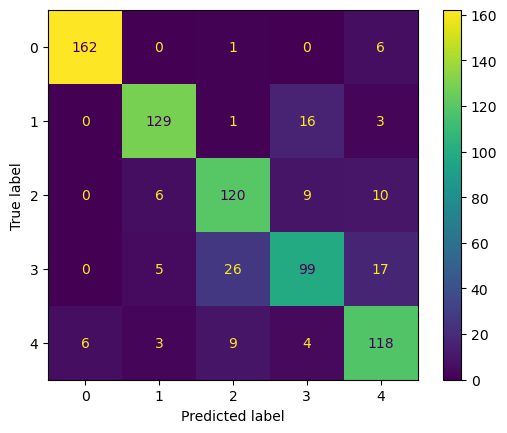

In [12]:
# Predecir las etiquetas del conjunto de prueba
y_pred = grid_search_gb.predict(x_test_processed)

# Hacer predicciones y evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy para el mejor modelo Gradient Boosting: {accuracy:.2f}')

# Informe de clasificación
print("\nInforme de clasificación para el mejor modelo Gradient Boosting:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión para el mejor modelo Gradient Boosting:")
cm_gb = confusion_matrix(y_test, y_pred)
disp_gb = ConfusionMatrixDisplay(confusion_matrix = cm_gb)
disp_gb.plot()

### Ensemble por el método Stacking

In [13]:
# Definir los modelos base
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Definir el meta-modelo
meta_model = LogisticRegression(solver='saga', verbose=1, multi_class='multinomial', max_iter=200)

# Crear el modelo de stacking
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=3)

# Definir la cuadrícula de hiperparámetros para el meta-modelo
param_grid_stacking = {
    'final_estimator__C': [0.1, 1.0, 10]
}

# Configurar la búsqueda grid search para el modelo de stacking
grid_search_stacking = GridSearchCV(estimator=stacking_clf, param_grid=param_grid_stacking, cv=2, scoring='accuracy')

start = time.time()
# Ejecutar la búsqueda
grid_search_stacking.fit(x_train_processed, y_train)

# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {end - start}")

# Mejores parámetros y puntuación
print("Mejores parámetros (Stacking):", grid_search_stacking.best_params_)
print("Mejor puntuación (Stacking):", grid_search_stacking.best_score_)

C:\Users\USER\anaconda3.0\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\USER\anaconda3.0\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 24 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 22 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 91 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 90 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


convergence after 79 epochs took 0 seconds
Tiempo de entrenamiento: 5396.42479801178
Mejores parámetros (Stacking): {'final_estimator__C': 10}
Mejor puntuación (Stacking): 0.849


Accuracy del mejor modelo Stacking: 0.86

Informe de clasificación del mejor modelo Stacking:
               precision    recall  f1-score   support

       Forest       0.99      0.96      0.98       169
   Industrial       0.91      0.88      0.89       149
PermanentCrop       0.77      0.83      0.80       145
  Residential       0.78      0.73      0.76       147
        River       0.82      0.86      0.84       140

     accuracy                           0.86       750
    macro avg       0.85      0.85      0.85       750
 weighted avg       0.86      0.86      0.86       750


Matriz de confusión del mejor modelo Stacking:


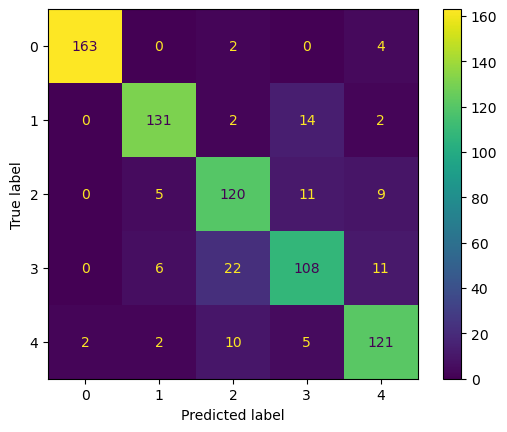

In [14]:
# Predecir las etiquetas del conjunto de prueba
y_pred = grid_search_stacking.predict(x_test_processed)

# Hacer predicciones y evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy del mejor modelo Stacking: {accuracy:.2f}')

# Informe de clasificación
print("\nInforme de clasificación del mejor modelo Stacking:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión del mejor modelo Stacking:")
cm_sm = confusion_matrix(y_test, y_pred)
disp_sm = ConfusionMatrixDisplay(confusion_matrix = cm_sm)
disp_sm.plot()